# Learning to Learning

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Problem

Let's define a function as:

$$
\boldsymbol{y} = \boldsymbol{f}(\mathbf{x})
$$

We can the function as

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) = \mathbf{wx}
$$

where $\boldsymbol{\theta}=\{ \mathbf{w}\}$ are the parameters

### Loss Function

$$
\boldsymbol{L}(\mathbf{x};\boldsymbol{\theta}) = 
||\mathbf{wx} 
- \mathbf{y} ||_2^2
$$

In [45]:
batch_size = 128
key = jrandom.PRNGKey(123)
key, *keys_params = jrandom.split(key, 4)

w = jrandom.normal(keys_params[0], (batch_size, 10, 10))
y = jrandom.normal(keys_params[1], (batch_size, 10))
x = jrandom.normal(keys_params[2], (batch_size, 10))

In [46]:
import equinox as eqx
from jaxtyping import Array, PRNGKeyArray

class LinearModel(eqx.Module):
    w: Array

    def __init__(
            self, 
            batchsize: int=10,
            ndims: int=10,
            key: PRNGKeyArray=jrandom.PRNGKey(123)
            ):
        self.w = jrandom.normal(key, (batchsize, ndims, ndims))

    def __call__(self, x):
        return jax.vmap(jnp.matmul)(self.w, x)

In [92]:
batchsize = 128
ndims = 10
key = jrandom.PRNGKey(123)
key, *keys_params = jrandom.split(key, 3)

y = jrandom.normal(keys_params[0], (batchsize, ndims))
x = jrandom.normal(keys_params[1], (batchsize, ndims))

lr_model  = LinearModel(ndims=ndims, batchsize=batchsize, key=keys_params[-1])

y_pred = lr_model(x)
assert y_pred.shape == y.shape

In [93]:
import typing as tp
class MSELoss(eqx.Module):
    model: tp.Callable

    def __init__(self, model):
        self.model = model
    
    def __call__(self, x, y):
        y_pred = self.model(x)
        return jnp.mean(jnp.sum((y_pred - y) ** 2, axis=1))

In [94]:
energy_fn = MSELoss(model=lr_model)

loss = energy_fn(x, y)

grad_fn = jax.value_and_grad(energy_fn, argnums=0)

In [126]:
import optax
from jaxtyping import PyTree

class TrainStateOptax(eqx.Module):
    params: Array
    optimizer: optax.GradientTransformation
    opt_state: optax.OptState

    def __init__(self, params: PyTree, optimizer: optax.GradientTransformation):
        self.params = params
        self.optimizer = optimizer
        self.opt_state = optimizer.init(params)


    @staticmethod
    def update_state(state: PyTree, grads: PyTree) -> PyTree:
        updates, opt_state = state.optimizer.update(
            grads, state.opt_state, params=state.params
        )
        params = optax.apply_updates(state.params, updates)

        state = eqx.tree_at(lambda x: x.params, state, params)
        state = eqx.tree_at(lambda x: x.opt_state, state, opt_state)
        return state


In [127]:
learning_rate = 1.0
optimizer = optax.sgd(learning_rate=learning_rate)
state_init = TrainStateOptax(x, optimizer)

In [128]:
from tqdm.autonotebook import trange
num_iterations = 100

state = TrainStateOptax(x, optimizer)
losses = dict(sgd=list())

with trange(num_iterations) as pbar:

    for i in pbar:
        
        loss, grads = grad_fn(state.params, y)

        state = state.update_state(state, grads)

        losses["sgd"].append(loss)
        pbar.set_description(desc=f"Loss: {loss:.4f}")

Loss: 109.5970:   0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.2364: 100%|██████████| 100/100 [00:00<00:00, 195.96it/s]


In [104]:
state.opt_state

(EmptyState(), EmptyState())

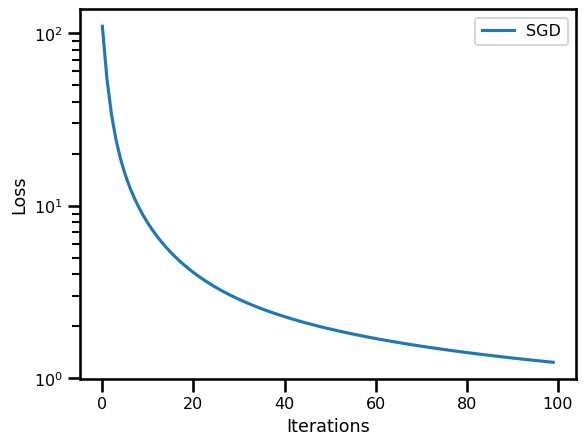

In [114]:
fig, ax = plt.subplots()

ax.plot(losses["sgd"], label="SGD")

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.legend()
plt.show()

In [106]:
learning_rate = 1.0
optimizer = optax.adamw(learning_rate=learning_rate)
state_init = OptState(x, optimizer)

In [122]:
opt_state = optimizer.init(x)

In [124]:
opt_state[0]

ScaleByAdamState(count=Array(0, dtype=int32), mu=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), nu=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [125]:
opt_state[1]

EmptyState()

In [107]:
num_iterations = 100

state = OptState(x, optimizer)
losses['adamw'] = list()

with trange(num_iterations) as pbar:

    for i in pbar:
        
        loss, grads = grad_fn(state.params, y)

        state = state.update_state(state, grads)

        losses["adamw"].append(loss)
        pbar.set_description(desc=f"Loss: {loss:.4f}")

Loss: 72.6050:   0%|          | 0/100 [00:00<?, ?it/s] 

Loss: 0.3328: 100%|██████████| 100/100 [00:00<00:00, 234.82it/s]


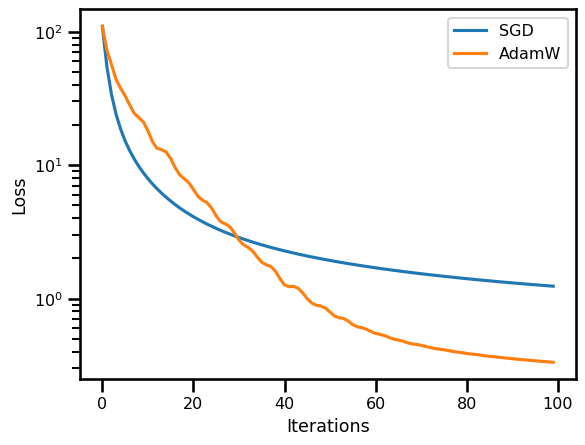

In [115]:
fig, ax = plt.subplots()

ax.plot(losses["sgd"], label="SGD")
ax.plot(losses["adamw"], label="AdamW")

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.legend()
plt.show()

In [116]:
learning_rate = 1.0
optimizer = optax.adam(learning_rate=learning_rate)
state_init = OptState(x, optimizer)

In [117]:
num_iterations = 100

state = OptState(x, optimizer)
losses['adam'] = list()

with trange(num_iterations) as pbar:

    for i in pbar:
        
        loss, grads = grad_fn(state.params, y)

        state = state.update_state(state, grads)

        losses["adam"].append(loss)
        pbar.set_description(desc=f"Loss: {loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.3322: 100%|██████████| 100/100 [00:00<00:00, 223.30it/s]


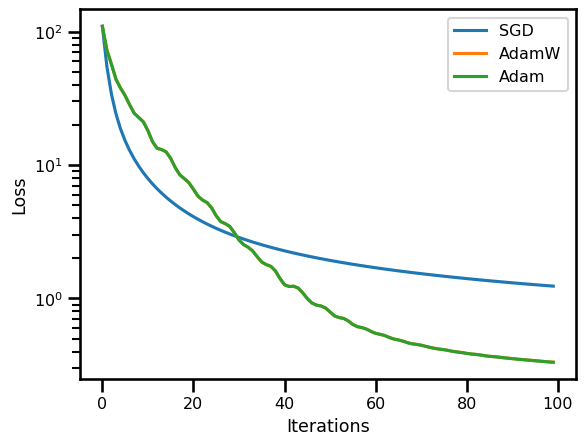

In [118]:
fig, ax = plt.subplots()

ax.plot(losses["sgd"], label="SGD")
ax.plot(losses["adamw"], label="AdamW")
ax.plot(losses["adam"], label="Adam")

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.legend()
plt.show()

Now, we can define a loss function as the MSE:

$$
\boldsymbol{L}(\mathbf{x};\boldsymbol{\theta}) = 
||\mathbf{wx} 
- \mathbf{y} ||_2^2
$$

$$
\boldsymbol{R}(\mathbf{x};\boldsymbol{\theta}) = 
\alpha||\mathbf{w}||_2^2
$$

$$
\mathbf{x}^*(\boldsymbol{\theta}) = 
\underset{\mathbf{x}}{\text{argmin}} \hspace{2mm}
\boldsymbol{J}(\mathbf{x};\boldsymbol{\theta})
$$

### Optimization

**Parameter Estimation**

$$
\mathbf{x}^{(k+1)} = 
\mathbf{x}^{(k)} +
\boldsymbol{g}_k
$$

The optimizer function, $\boldsymbol{g}(\cdot)$, defined as:

$$
\left[ \boldsymbol{g}_k, \boldsymbol{h}_{k+1}\right] =
\boldsymbol{g}
\left( \boldsymbol{\nabla}_{\mathbf{x}}\boldsymbol{L}(\mathbf{x};\boldsymbol{\theta}), \boldsymbol{h}_k \right)
$$

In [2]:
import typing as tp
import equinox as eqx
from jaxtyping import Array


class LinearModel(eqx.Module):
    weight: Array

    def __init__(self, dim_in, dim_out, key=jrandom.PRNGKey(123)):

        self.weight = jrandom.normal(key=key, shape=(dim_out, dim_in))

    def __call__(self, x):
        return jnp.matmul(self.weight, x)
    



In [43]:
x_true = jnp.linspace(-1,1, 100)

key = jrandom.PRNGKey(123)

def f(x, noise: float=0.05):
    return 0.25 * x + noise * jrandom.normal(key, shape=(x.shape[0],))
y_true = f(x_true, noise=0.0)
y_noisy = f(x_true, noise=0.05)

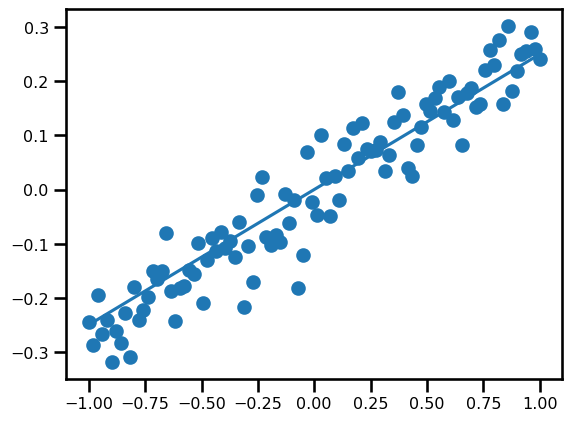

In [44]:
fig, ax = plt.subplots()

ax.plot(x_true, y_true)
ax.scatter(x_true, y_noisy)

plt.show()

**Objective Function**

$$
\boldsymbol{J}(\mathbf{x};\boldsymbol{\theta}) =
\boldsymbol{L}(\mathbf{x};\boldsymbol{\theta}) +
\lambda
\boldsymbol{R}(\mathbf{x};\boldsymbol{\theta})
$$

**Data Fidelity Term**

$$
\begin{aligned}
\boldsymbol{L}(\mathbf{x};\boldsymbol{\theta}) &=
||\mathbf{y} - \boldsymbol{f}(\mathbf{x};\boldsymbol{\theta})||_2^2 \\
&= ||\mathbf{y} - \mathbf{xw}||_2^2
\end{aligned}
$$

**Regularization Term**

$$
\begin{aligned}
\boldsymbol{R}(\boldsymbol{\theta}) &=
||\boldsymbol{\theta}||_2^2 \\
&= ||\mathbf{w}||_2^2
\end{aligned}
$$

In [13]:
class RidgeLoss(eqx.Module):
    alpha: Array
    model: tp.Callable = LinearModel

    def __init__(self, model: tp.Callable, alpha=0.1):
        self.model = model
        self.alpha = jnp.asarray(alpha)

    def data_loss(self, x, y):
        y_pred = self.model(x)
        return jnp.mean(y_pred - y)
    
    def reg_loss(self):
        return jnp.sum(self.model.weight ** 2)

    def loss(self, x, y, return_losses: bool=False):
        
        # data loss
        data_loss = self.data_loss(x, y)

        # reg loss
        reg_loss = self.alpha * self.reg_loss()

        # total loss
        loss = data_loss + reg_loss

        if return_losses:
            losses = dict(loss=loss, data=data_loss, reg=reg_loss)
            return loss, losses
        else:
            return loss


In [14]:
x = jnp.ones((10,))
y = jnp.ones((1,))

lr_model = LinearModel(10, 1)
y_pred = lr_model(x)
y_pred.shape, y.shape

((1,), (1,))

In [15]:
ridge_loss = RidgeLoss(lr_model, alpha=0.01)

ridge_loss.loss(x, y, return_losses=True)

(Array(-4.153241, dtype=float32),
 {'loss': Array(-4.153241, dtype=float32),
  'data': Array(-4.251601, dtype=float32),
  'reg': Array(0.09835989, dtype=float32)})

In [16]:
def jaxopt_loss(model, x, y):
    return model.loss(x, y)

$$
\mathbf{x}^*(\boldsymbol{\theta}) =
\underset{\mathbf{x}}{\text{argmin}} \hspace{2mm}
\boldsymbol{J}(\mathbf{x};\boldsymbol{\theta})
$$

In [17]:
from jaxopt import OptaxSolver
import jaxopt
import optax

learning_rate = 1e-3
maxiter = 100

opt = optax.adam(learning_rate)
# solver = OptaxSolver(opt=opt, fun=jaxopt_loss, maxiter=1000)

In [21]:
solver = jaxopt.LBFGS(fun=jaxopt_loss, maxiter=maxiter)
res = solver.run(ridge_loss, x=x, y=y)

# Alternatively, we could have used one of these solvers as well:
# solver = jaxopt.GradientDescent(fun=ridge_reg_objective, maxiter=500)
# solver = jaxopt.ScipyMinimize(fun=ridge_reg_objective, method="L-BFGS-B", maxiter=500)
# solver = jaxopt.NonlinearCG(fun=ridge_reg_objective, method="polak-ribiere", maxiter=500)

print(res.params.model)

LinearModel(weight=f32[1,10])


In [22]:
res.params.model.weight

Array([[-0.10502207, -0.56205004, -0.56485987, -1.7063935 ,  0.56626016,
        -0.42215332,  1.0077653 ,  0.9922631 , -0.61236995, -1.8450408 ]],      dtype=float32)

In [9]:

opt = optax.adam(learning_rate)

def jaxopt_soln(x, y):
  gd = OptaxSolver(opt=opt, fun=jaxopt_loss, maxiter=1000, implicit_diff=True)
  # gd = jaxopt.LBFGS(fun=jaxopt_loss, maxiter=500, implicit_diff=True, )
  # gd = jaxopt.GradientDescent(fun=jaxopt_loss, maxiter=500, implicit_diff=True, )
  return gd.run(ridge_loss, x=x, y=y).params

In [10]:
soln  = jaxopt_soln(x, y)
soln.alpha

Array(-1.2881405, dtype=float32)

In [11]:
res.params.alpha, res.params.model.weight

(Array(0.01, dtype=float32),
 Array([[-0.10502207, -0.56205004, -0.56485987, -1.7063935 ,  0.56626016,
         -0.42215332,  1.0077653 ,  0.9922631 , -0.61236995, -1.8450408 ]],      dtype=float32))

In [12]:
res.state

LbfgsState(iter_num=Array(100, dtype=int32, weak_type=True), value=Array(-2.0766206, dtype=float32), grad=RidgeLoss(alpha=f32[], model=LinearModel(weight=f32[1,10])), stepsize=Array(0., dtype=float32), error=Array(5.1628613, dtype=float32), s_history=RidgeLoss(alpha=f32[10], model=LinearModel(weight=f32[10,1,10])), y_history=RidgeLoss(alpha=f32[10], model=LinearModel(weight=f32[10,1,10])), rho_history=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), gamma=Array(1., dtype=float32), aux=None, failed_linesearch=Array(True, dtype=bool))